# Overview:

## Broadband Sensitivity Calculations:
1. Import Excel Spreadsheet.py
2. Call calcByAngle and store in a variable to create a function from observation zenith angle to various outputs
3. Call created function with requested angle from zenith. *This is 90 - elevation angle*
4. Create output display functions if necessary
5. Call requested results

[0.76390292 0.49038857 0.60958542 0.47873857 0.40693271]
beam:  [15.31558919 32.14382916 37.4087667  45.67807302 58.64076942]
NEP weighted avrage:  [1.74810515e+05 1.85451938e+02 6.10952271e+01 1.38741392e+01
 7.71900364e+00]


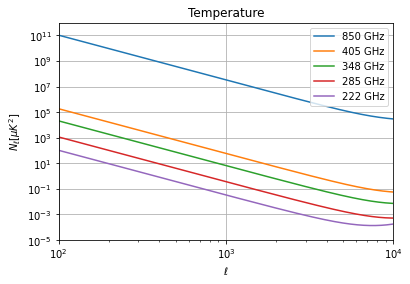

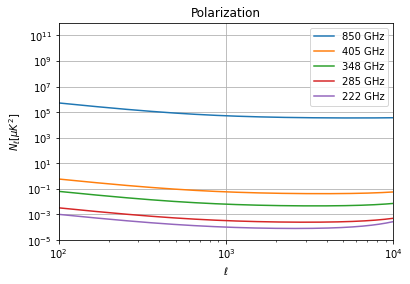

In [1]:
import sensitivity_calculator as sens
import numpy as np
import matplotlib.pyplot as plt

# t_filter_cold and feedhorn beam file used for spill calculations should be refined further.

inputs = {'diameter': 5.7, 't': 273, 'wfe': 10.7, 'eta': 0.98, 'doe': 0.8, 't_int': 1, 'pixelYield': 0.8, 
        'szCamNumPoln': 1, 'eorSpecNumPoln': 2, 't_filter_cold': np.array([0.593, 0.84 , 0.909, 0.922, 0.89 ]), 
        't_lens_cold': np.array([0.98, 0.98, 0.98, 0.98, 0.98]), 
        't_uhdpe_window': np.array([0.96, 0.97, 0.97, 0.97, 0.97]), 
        'singleModedAOmegaLambda2': np.array([1., 1., 1., 1., 1.]), 
        'spatialPixels': np.array([39762, 20808, 10368, 10368,  7938]), 
        'eqbw': np.array([9.7e+10, 3.0e+10, 3.6e+10, 7.0e+10, 5.6e+10]), 
        'centerFrequency': np.array([8.50e+11, 4.05e+11, 3.48e+11, 2.85e+11, 2.22e+11]), 'detectorNEP': 0, 
        'backgroundSubtractionDegradationFactor': 1, 'r': np.array([[100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.]]), 
        'decimalPlaces': 3, 'observationElevationAngle': 45, 'outputFreq': True, 
        'detectorSpacing': np.array([1.45, 1.97, 2.75, 2.75, 3.13]), 'lyotStopAngle': 13.4}
# Alternatively, sens.getInputs("input.yaml")

spillEfficiency = sens.getSpillEfficiency(inputs, oldFile=True)
print(spillEfficiency)
calculate = sens.calcByAngle(inputs["diameter"], inputs["t"], inputs["wfe"], inputs["eta"], inputs["doe"], inputs["t_int"], inputs["pixelYield"], inputs["szCamNumPoln"], inputs["eorSpecNumPoln"],
                            inputs["t_filter_cold"], inputs["t_lens_cold"], inputs["t_uhdpe_window"], spillEfficiency, inputs["singleModedAOmegaLambda2"],
                            inputs["spatialPixels"], inputs["eqbw"], inputs["centerFrequency"], inputs["detectorNEP"],
                            inputs["backgroundSubtractionDegradationFactor"], inputs["r"])

outputs = calculate(90-inputs['observationElevationAngle'])

print("beam: ", outputs["beam"])
print("NEP weighted avrage: ", outputs['netW8Avg'])

ell, N_ell_T_full, N_ell_P_full = sens.getNoiseCurves(inputs, outputs, el=45,atmosphere=True,
                                                      survey_hours=4000, sky_area=24752.9)

for curves, labels, title in zip([N_ell_T_full, N_ell_P_full], [inputs["centerFrequency"]] * 2, ["Temperature", "Polarization"]):
    for curve, label in zip(curves, labels):
        plt.plot(ell, curve, label=str(int(label/1e9))+' GHz')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(10**2, 10**4)
    plt.ylim(10**-5, 10**12)
    plt.xlabel('$\ell$')
    plt.ylabel('$N_\ell [\mu K^2]$')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

## EoR Calculations
1. Import sensitivity calculator
2. Create dictonary of parameters specifying detector
3. Create list of pairs of finesse and frequency values to get noise curves for
4. Call sens.eorNoiseCurves
5. Index specific noise curve from returned dictonary

In [2]:
eor_inputs = {'diameter': 5.7, 't': 273, 'wfe': 10.7, 'eta': 0.98, 'doe': 0.8, 'pixelYield': 0.8,
              'eorSpecNumPoln': 2, 't_filter_cold': np.array([1, 1]), 't_lens_cold': np.array([.98, .98]), 't_uhdpe_window': np.array([1, 1]), 'spatialPixels': np.array([3456, 3072]),
              'centerFrequency': np.array([262.5*10**9, 367.5*10**9]), 'detectorNEP': 0,
              'backgroundSubtractionDegradationFactor': 1, 'observationElevationAngle': 45, 'detectorSpacing': np.array([2.75, 2.09]), 'lyotStopAngle': 13.4}
# diameter is the diameter of the telescope in m
# t is the temperature of the telescope in K
# wfe is wave front error in um
# eta is telescope efficiency
# doe is detector quantum efficiency; loss due to superconducting detectors
# pixelYield is the proportion of working pixels
# eorSpecNumPoln is the number of polarization modes for EoR spectrometers
# t_filter_cold, t_lens_cold, and t_uhdpe_window all characterize the throughput of the instruments. However, we don't have experimental values for these yet, so they currently are an estimation.
# spatialPixels is the total number of pixels on all arrays
# centerFrequency is the center of the frequency range for the detector arrays
# detectorNEP is the NEP from the detector itself
# backgroundSubtractionDegradationFactor is an efficiency loss factor from post analysis removing of common atmospheric noise
# observationElevationAngle is the angle above the horizon that the telescope is observing
# detectorSpacing is the distance between pixels in the arrays in mm
# lyotStopAngle is the angle from the detectors to the lyot stop, which controls the spill efficiency

rfpairs = np.array([(100, 250*10**9), (150, 350*10**9), (1000, 400*10**9)])
# rfpairs is a list of (resolving power, center frequency) to get noise curves for
# Note that center frequency is in Hz

allCurves = sens.eorNoiseCurves(eor_inputs, rfpairs)
ell_250, N_ell_T_full_250, N_ell_P_full_250 = allCurves[(100, 250*10**9)]
ell_400, N_ell_T_full_400, N_ell_P_full_400 = allCurves[(1000, 400*10**9)]

## Map Simulations
1. Run broadband calculations.
2. Call ccat_mapsims with input parameters, output from broadband calculations, band and tube of detector, pysm components (if wanted), seed (if wanted), whether to simulate the cmb, and whether to simulate noise.
3. Feed to healpy's anafast to analyze the power spectrum.

f_sky: 0.6000270495442267
sky_area: 24752.89262345136


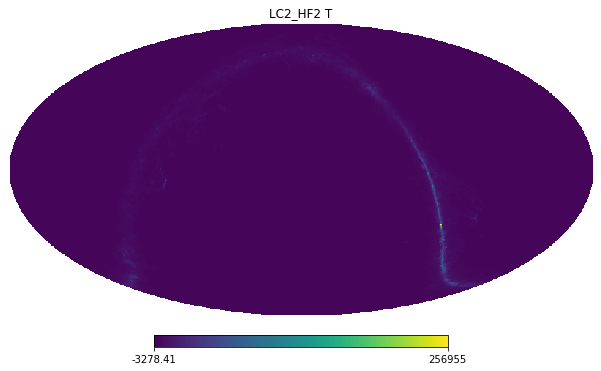

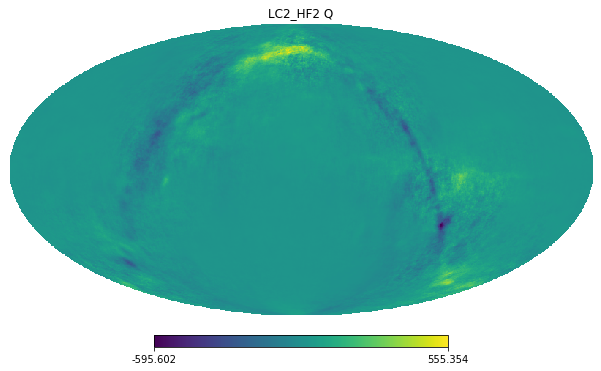

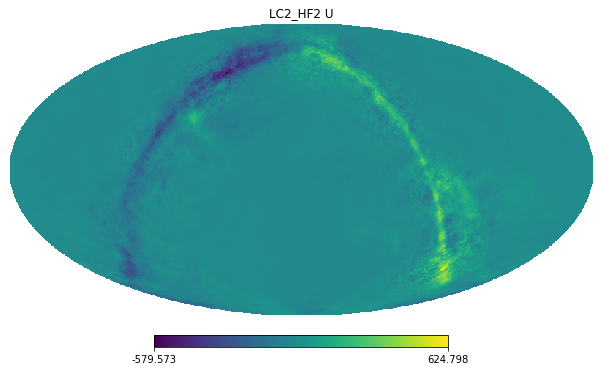

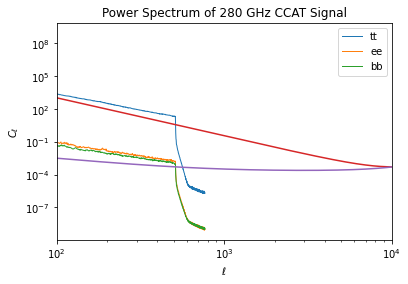

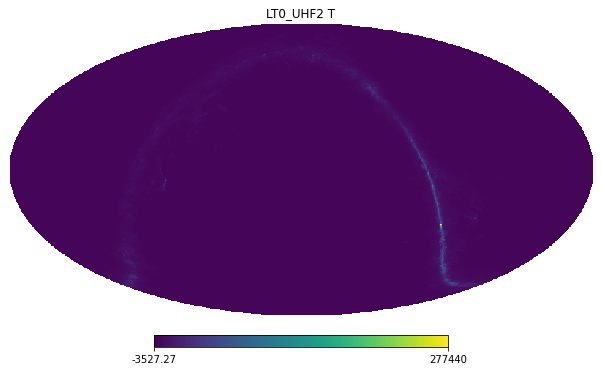

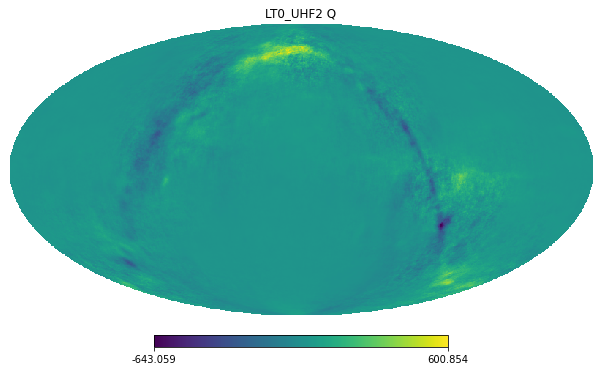

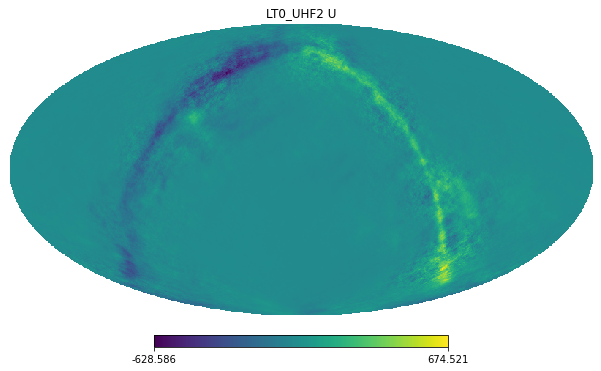

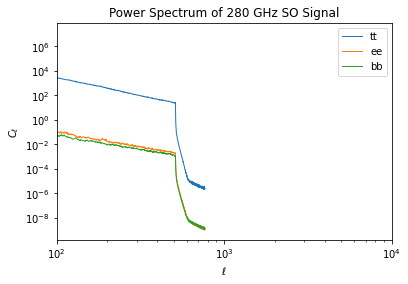

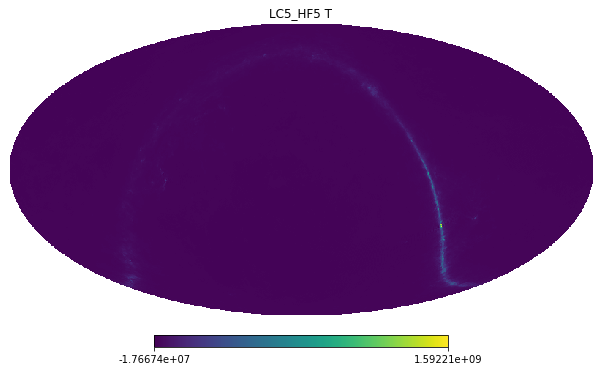

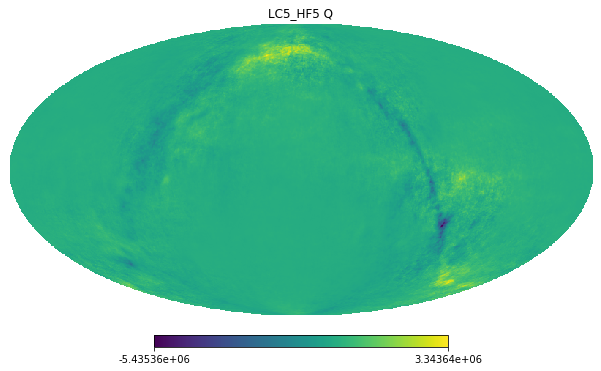

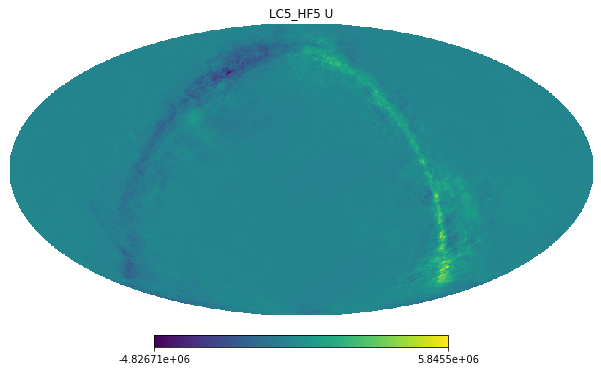

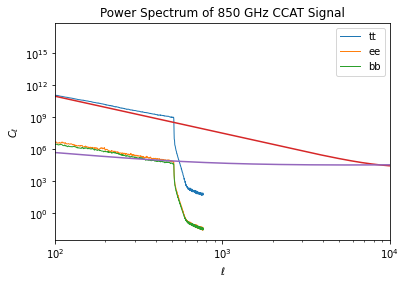

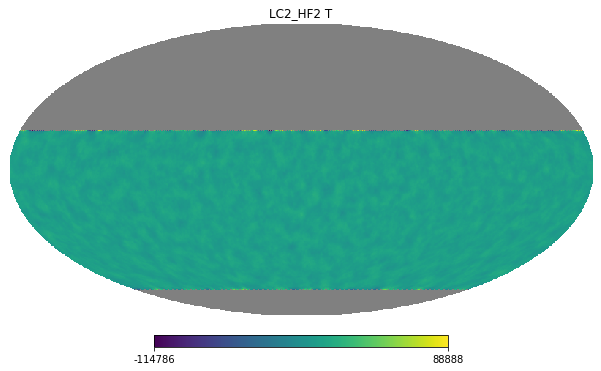

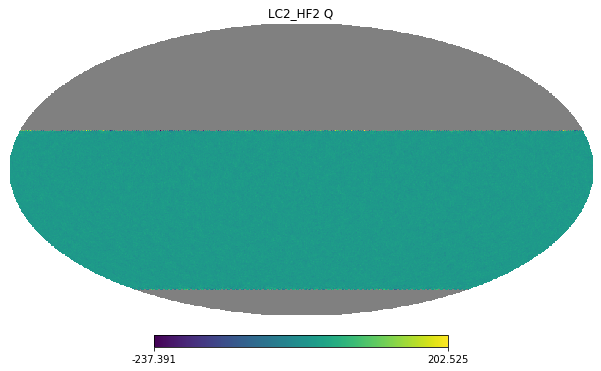

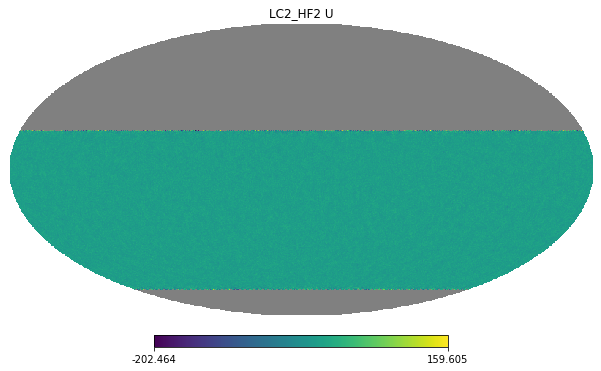

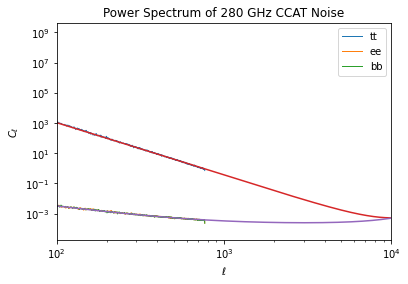

Retrieve data for LT0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz (if not cached already)
Retrieve data for LT0_UHF2_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz (if not cached already)


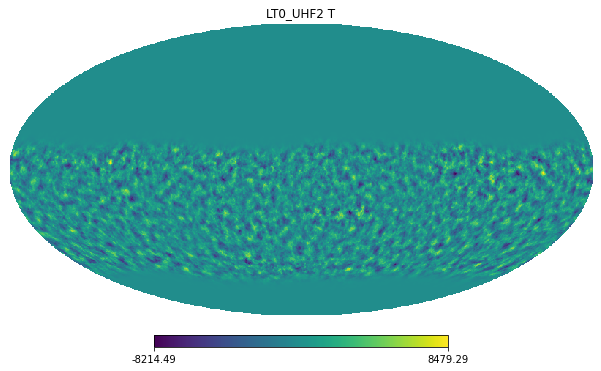

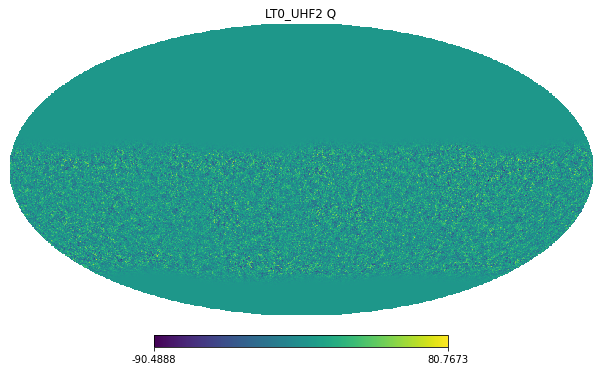

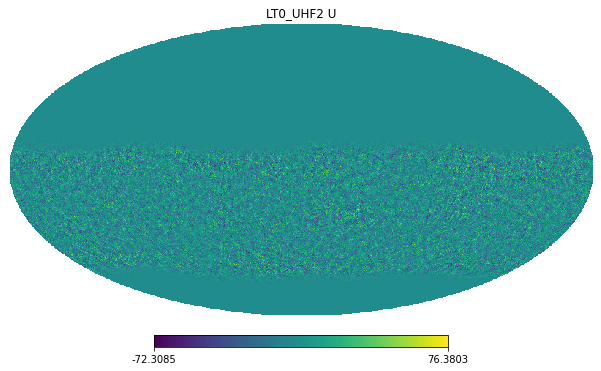

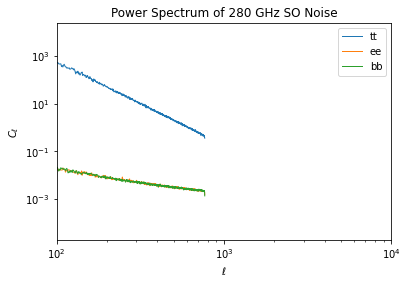

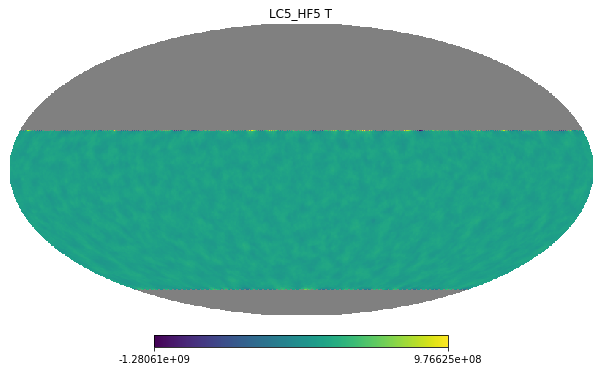

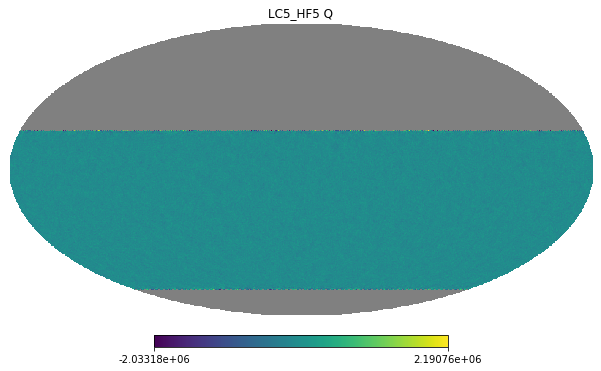

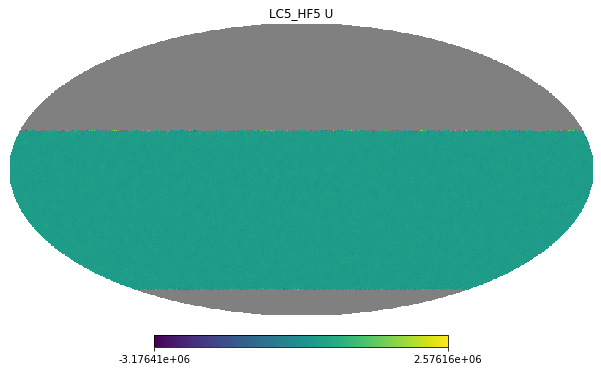

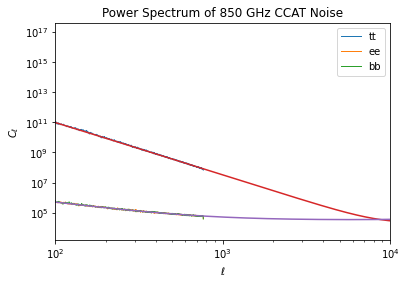

In [3]:
import healpy as hp

seed = 0
np.random.seed(seed)
NSIDE = 256
hitmap_path = "src/sensitivity_calculator/data/ccat_uniform_coverage_nside" + str(NSIDE) + "_201021.fits"
# zf = sens.zeroHitmapFraction(hitmap_path, NSIDE)
def get_hivon_fsky(mask):
    npix = len(mask)
    non0 = np.where(mask!=0)[0]
    fs = len(non0)/float(npix)
    w2 = np.sum(mask[non0]**2)/(npix*fs)
    w4 = np.sum(mask[non0]**4)/(npix*fs)
    return fs*w2**2/w4

hitmap = hp.ud_grade(
            hp.read_map(hitmap_path, dtype=np.float64),
            nside_out=NSIDE,
        )

fsky = get_hivon_fsky(hitmap)
sky_area = fsky*4*np.pi*(180/np.pi)**2

print("f_sky:", fsky)
print("sky_area:", sky_area)

data_C = sens.sensitivity._data_C_calcV2(inputs)

for pysm_components, sim_noise in zip(["d2,cib1", None], [False, True]):
    ccat280 = sens.ccat_mapsims(
        inputs, outputs, "HF2", "LC2", pysm_components, seed, data_C, sim_cmb=False, sim_noise=sim_noise, hitmap_path=hitmap_path, NSIDE=NSIDE)
    ccat280cls = hp.sphtfunc.anafast(ccat280*hitmap)/fsky
    sens.plotPowerSpectrum(ccat280cls[0], ccat280cls[1], ccat280cls[2],
                      "280 GHz CCAT " + ("Noise" if sim_noise else "Signal"), zf=1, TT_theory=N_ell_T_full[3], PP_theory=N_ell_P_full[3])
                           

    so280 = sens.so_mapsims("UHF2", "LT0", pysm_components,
                       seed, sim_cmb=False, sim_noise=sim_noise, NSIDE=NSIDE, hitmap=hitmap)
    so280cls = hp.sphtfunc.anafast(so280*hitmap)/fsky
    sens.plotPowerSpectrum(so280cls[0], so280cls[1], so280cls[2],
                      "280 GHz SO " + ("Noise" if sim_noise else "Signal"), zf=1)

    ccat850 = sens.ccat_mapsims(
        inputs, outputs, "HF5", "LC5", pysm_components, seed, data_C, sim_cmb=False, sim_noise=sim_noise, hitmap_path=hitmap_path, NSIDE=NSIDE)
    ccat850cls = hp.sphtfunc.anafast(ccat850*hitmap)/fsky
    sens.plotPowerSpectrum(ccat850cls[0], ccat850cls[1], ccat850cls[2],
                      "850 GHz CCAT " + ("Noise" if sim_noise else "Signal"), zf=1, TT_theory=N_ell_T_full[0], PP_theory=N_ell_P_full[0])

